In [2]:
from typing_extensions import TypedDict
import random
from typing import Literal

from langgraph.graph import StateGraph, START, END
from IPython.display import display, Markdown, Image

In [3]:
class State(TypedDict):
    game_state: str

* Node 1: Prompts the use for input
* Node 2: Represents a successful outcome.
* Node 3: Represents a failure outcome

In [4]:
def node_1(state: State):
    print("Node 1")
    state['game_state'] = input("I am betting the roll will be lower than or equal to: ")
    return state

def node_2(state: State):
    print("Node 2")
    state['game_state'] = "success"
    return state

def node_3(state: State):
    print("Node 3")
    state['game_state'] = "failure"
    return state

In [5]:
# implement a conditional edge between 2 and 3
def determine_outcome(state) -> Literal['node_2', 'node_3']:
    roll = random.randint(1,6) + random.randint(1,6)
    print(f"[Decision] Rolled; {roll}")
    bet = int(state['game_state'])

    return 'node_2' if roll <= bet else 'node_3'

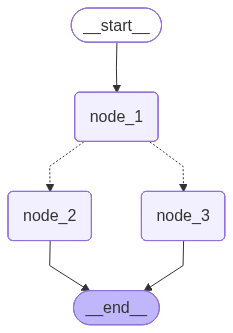

In [6]:
# build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", determine_outcome)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# compile graph
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [8]:
graph.invoke({})

Node 1
[Decision] Rolled; 2
Node 2


{'game_state': 'success'}

# Agents in LangGraph

In [9]:
from typing import Annotated
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState

/Users/shugney20/Documents/genai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import os, getpass
import json

file_name = '../config.json'
with open(file_name, 'r') as file:
    config = json.load(file)
    API_KEY = config.get("API_KEY") # Loading the API Key
    OPENAI_API_BASE = config.get("OPENAI_API_BASE") # Loading the API Base Url
# Storing API credentials in environment variables
os.environ['OPENAI_API_KEY'] = API_KEY
os.environ["OPENAI_BASE_URL"] = OPENAI_API_BASE

In [ ]:
from langchain_openai import ChatOpenAI
gpt4o_chat = ChatOpenAI(model = "gpt-4o", temperature = 0)
gpt4o_chat.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 13, 'total_tokens': 43, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_c98e05ca17', 'id': 'chatcmpl-CiCmhxZbdd4BtZuzCI2EzH31zd6iC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--8ef1b4c2-f0ff-4904-b5a5-5f7a09a6ae7b-0', usage_metadata={'input_tokens': 13, 'output_tokens': 30, 'total_tokens': 43, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
def multiply(a: int, b: int) -> int:
    """ 
    Multiply a and b 
    Args:
        a: int
        b: int
    Returns:
        int: The product of a and b
    """
    return a * b

def add(a: int, b: int) -> int:
    """ 
    Add a and b 
    Args:
        a: int
        b: int
    Returns:
        int: The sum of a and b
    """
    return a + b


In [ ]:
def determine_outcome(bet: int) -> str:
    """ 
    Roll a pair of dice and determine whetere the sum of that roll is less than or equal to the bet.
    Args:
        bet: int
    Returns:
        str: "success" if the roll is less than or equal to the bet, "failure" otherwise
    """
    roll = random.randint(1,6) + random.randint(1,6)
    return "success" if roll <= bet else "failure"

In [ ]:
llm_with_tools = gpt4o_chat.bind_tools([multiply, add, determine_outcome])

In [ ]:
tool_call = llm_with_tools.invoke([HumanMessage(content = f"What is 2 times 3?")])
tool_call.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_fmo2Vf2jutAcRVmE5IfjP7Am)
 Call ID: call_fmo2Vf2jutAcRVmE5IfjP7Am
  Args:
    a: 2
    b: 3


In [ ]:
class MessagesState(MessagesState):
    pass


In [ ]:
# inital state
initial_messages = [AIMessage(content = "Hello! How can I assist you?", name = "Model"),
                    HumanMessage(content="I need help understanding probability theory.", name = "User")]
new_message = AIMessage(content = "Sure, I can help with that. What specifically are you interested in?", name = "Model")

add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='d2cb4489-944b-495f-a108-ed8699c01bb0'),
 HumanMessage(content='I need help understanding probability theory.', additional_kwargs={}, response_metadata={}, name='User', id='723fb979-342e-40f2-a7d3-635ef8065869'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='330a2c52-a711-4e2d-9879-66ab9bfb84a0')]

In [ ]:
# create chain
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)


In [ ]:
graph = builder.compile()


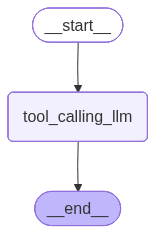

In [ ]:

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content = "Hello")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [ ]:
messages = graph.invoke({"messages": HumanMessage(content = "Multiply 5 and 7")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 5 and 7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_8FPtBhvQBhhSj0T5yhFsFroz)
 Call ID: call_8FPtBhvQBhhSj0T5yhFsFroz
  Args:
    a: 5
    b: 7


In [ ]:
messages = graph.invoke({"messages": HumanMessage(content = "bet 6 against a dice roll")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

bet 6 against a dice roll
================================== Ai Message ==================================
Tool Calls:
  determine_outcome (call_yWoQry7TW1YHsAGriQ5N4vG8)
 Call ID: call_yWoQry7TW1YHsAGriQ5N4vG8
  Args:
    bet: 6


# create a router

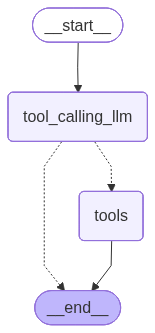

In [ ]:
# node
def tool_calling_llm(state:MessagesState):
    return{"messages": [llm_with_tools.invoke(state["messages"])]}

# build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply, add, determine_outcome]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    # if latest was a tool call, send to tool, else send to end
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
messages = graph.invoke({"messages": HumanMessage(content = "Hello")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [ ]:
messages = graph.invoke({"messages": HumanMessage(content = "Multiply 5 and 7")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 5 and 7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_9Hy9hM8xvZ4ViIElKmDeB74n)
 Call ID: call_9Hy9hM8xvZ4ViIElKmDeB74n
  Args:
    a: 5
    b: 7
================================= Tool Message =================================
Name: multiply

35


In [ ]:
messages = graph.invoke({"messages": HumanMessage(content = "bet 6 against a dice roll")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

bet 6 against a dice roll
================================== Ai Message ==================================
Tool Calls:
  determine_outcome (call_9SBFDAtV7Ot252jys5ngCjs7)
 Call ID: call_9SBFDAtV7Ot252jys5ngCjs7
  Args:
    bet: 6
================================= Tool Message =================================
Name: determine_outcome

failure


# Create an Agent

In [ ]:
# system message
sys_msg = SystemMessage(content = "You are a helpful assistant tasked with performing arithmetic to determine the bet and resolving whether that bet passes a dice roll test ")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state['messages'])]}b


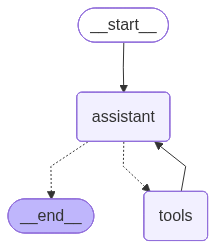

In [ ]:
# graph
builder = StateGraph(MessagesState)

#define the nodes (these do the work)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([add, multiply, determine_outcome]))

# define the edges: the determines the workflow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

display(Image(react_graph.get_graph().draw_mermaid_png()))



In [ ]:
messages = [HumanMessage(content = "My defender has a +2 defense. The attack has a +1 modifier for range and a +2 modifier for moving"),
"I need to detemine whether the defender passes the attack role by summing together the defense modifiers and checking that outcome against the die roll"]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

My defender has a +2 defense. The attack has a +1 modifier for range and a +2 modifier for moving
================================ Human Message =================================

I need to detemine whether the defender passes the attack role by summing together the defense modifiers and checking that outcome against the die roll
================================== Ai Message ==================================
Tool Calls:
  add (call_kk40gs2lDDHpTHxganjODgbO)
 Call ID: call_kk40gs2lDDHpTHxganjODgbO
  Args:
    a: 2
    b: 1
  add (call_zlp2ulKCcdYzoQLU9wlKKbpB)
 Call ID: call_zlp2ulKCcdYzoQLU9wlKKbpB
  Args:
    a: 1
    b: 2
================================= Tool Message =================================
Name: add

3
================================= Tool Message =================================
Name: add

3
================================== Ai Message ==================================
Tool Calls:
  ad